In [1]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.metrics as metrics
from keras.models import Sequential
from keras.layers import Dense, LSTM, Flatten, Dropout

Using TensorFlow backend.


In [2]:
# This function lists out all permutations of ace values in the array sum_array
# For example, if you have 2 aces, there are 4 permutations:
#     [[1,1], [1,11], [11,1], [11,11]]
# These permutations lead to 3 unique sums: [2, 12, 22]
# Of these 3, only 2 are <=21 so they are returned: [2, 12]
def get_ace_values(temp_list):
    sum_array = np.zeros((2**len(temp_list), len(temp_list)))
    # This loop gets the permutations
    for i in range(len(temp_list)):
        n = len(temp_list) - i
        half_len = int(2**n * 0.5)
        for rep in range(int(sum_array.shape[0]/half_len/2)):
            sum_array[rep*2**n : rep*2**n+half_len, i] = 1
            sum_array[rep*2**n+half_len : rep*2**n+half_len*2, i] = 11
    # Only return values that are valid (<=21)
    # return list(set([int(s) for s in np.sum(sum_array, axis=1) if s<=21]))
    return [int(s) for s in np.sum(sum_array, axis=1)]

# Convert num_aces, an int to a list of lists
# For example if num_aces=2, the output should be [[1,11],[1,11]]
# I require this format for the get_ace_values function
def ace_values(num_aces):
    temp_list = []
    for i in range(num_aces):
        temp_list.append([1,11])
    return get_ace_values(temp_list)

In [3]:
# Make a deck
def make_decks(num_decks, card_types):
    new_deck = []
    for i in range(num_decks):
        for j in range(4):
            new_deck.extend(card_types)
    random.shuffle(new_deck)
    return new_deck

# Total up value of hand
def total_up(hand):
    aces = 0
    total = 0
    
    for card in hand:
        if card != 'A':
            total += card
        else:
            aces += 1
    
    # Call function ace_values to produce list of possible values for aces in hand
    ace_value_list = ace_values(aces)
    final_totals = [i+total for i in ace_value_list if i+total<=21]
    
    if final_totals == []:
        return min(ace_value_list) + total
    else:
        return max(final_totals)
    
# Play a game of blackjack (after the cards are dealt)
def play_game(dealer_hand, player_hands, blackjack, curr_player_results, dealer_cards, hit_stay, card_count, dealer_bust):
    action = 0
    # Dealer checks for 21
    if set(dealer_hand) == blackjack:
        for player in range(players):
            if set(player_hands[player]) != blackjack:
                curr_player_results[0,player] = -1
            else:
                curr_player_results[0,player] = 0
    else:
        for player in range(players):
            # Players check for 21
            if set(player_hands[player]) == blackjack:
                curr_player_results[0,player] = 1
            else:
                # Hit randomly, check for busts
                if (hit_stay >= 0.5) and (total_up(player_hands[player]) != 21):
                    player_hands[player].append(dealer_cards.pop(0))
                    card_count[player_hands[player][-1]] += 1
                    
                    action = 1
                    live_total.append(total_up(player_hands[player]))
                    if total_up(player_hands[player]) > 21:
                        curr_player_results[0,player] = -1

    # Dealer hits based on the rules
    card_count[dealer_hand[-1]] += 1
    while total_up(dealer_hand) < 17:
        dealer_hand.append(dealer_cards.pop(0))
        card_count[dealer_hand[-1]] += 1
        
    # Compare dealer hand to players hand but first check if dealer busted
    if total_up(dealer_hand) > 21:
        dealer_bust.append(1)
        for player in range(players):
            if curr_player_results[0,player] != -1:
                curr_player_results[0,player] = 1
    else:
        dealer_bust.append(0)
        for player in range(players):
            if total_up(player_hands[player]) > total_up(dealer_hand):
                if total_up(player_hands[player]) <= 21:
                    curr_player_results[0,player] = 1
            elif total_up(player_hands[player]) == total_up(dealer_hand):
                curr_player_results[0,player] = 0
            else:
                curr_player_results[0,player] = -1
                
    return curr_player_results, dealer_cards, action, card_count, dealer_bust

In [194]:
stacks = 40000
players = 1
num_decks = 1

card_types = ['A',2,3,4,5,6,7,8,9,10,10,10,10]

dealer_card_feature = []
player_card_feature = []
player_live_total = []
player_live_action = []
player_results = []
dealer_bust = []

first_game = True
prev_stack = 0
stack_num_list = []
new_stack = []
card_count_list = []
games_played_with_stack = []

for stack in range(stacks):
    games_played = 0
    
    # Make a dict for keeping track of the count for a stack
    card_count = {2: 0,
                  3: 0,
                  4: 0,
                  5: 0,
                  6: 0,
                  7: 0,
                  8: 0,
                  9: 0,
                  10: 0,
                  'A': 0}
    
    blackjack = set(['A',10])
    dealer_cards = make_decks(num_decks, card_types)
    while len(dealer_cards) > 20:
        
        curr_player_results = np.zeros((1,players))
        
        dealer_hand = []
        player_hands = [[] for player in range(players)]
        live_total = []
        live_action = []

        # Deal FIRST card
        for player, hand in enumerate(player_hands):
            player_hands[player].append(dealer_cards.pop(0))
            card_count[player_hands[player][-1]] += 1
            
        dealer_hand.append(dealer_cards.pop(0))
        card_count[dealer_hand[-1]] += 1
        
        # Deal SECOND card
        for player, hand in enumerate(player_hands):
            player_hands[player].append(dealer_cards.pop(0))
            card_count[player_hands[player][-1]] += 1
            
        dealer_hand.append(dealer_cards.pop(0))
        
        # Record the player's live total after cards are dealt
        live_total.append(total_up(player_hands[player]))
        
        if stack < stacks/2:
            hit_stay = 1
        else:
            hit_stay = 0
            
        curr_player_results, dealer_cards, action, card_count, dealer_bust = play_game(dealer_hand, player_hands, 
                                                                          blackjack, curr_player_results, 
                                                                          dealer_cards, hit_stay, card_count,
                                                                          dealer_bust)
        
        # Track features
        dealer_card_feature.append(dealer_hand[0])
        player_card_feature.append(player_hands)
        player_results.append(list(curr_player_results[0]))
        player_live_total.append(live_total)
        player_live_action.append(action)
        
        # Update card count list with most recent game's card count
        if stack != prev_stack:
            new_stack.append(1)
        else:
            new_stack.append(0)
            if first_game == True:
                first_game = False
            else:
                games_played += 1
            
        stack_num_list.append(stack)
        games_played_with_stack.append(games_played)
        card_count_list.append(card_count.copy())
        prev_stack = stack

model_df = pd.DataFrame()
model_df['dealer_card'] = dealer_card_feature
model_df['player_total_initial'] = [total_up(i[0][0:2]) for i in player_card_feature]
model_df['hit?'] = player_live_action

has_ace = []
for i in player_card_feature:
    if ('A' in i[0][0:2]):
        has_ace.append(1)
    else:
        has_ace.append(0)
model_df['has_ace'] = has_ace

dealer_card_num = []
for i in model_df['dealer_card']:
    if i=='A':
        dealer_card_num.append(11)
    else:
        dealer_card_num.append(i)
model_df['dealer_card_num'] = dealer_card_num

model_df['Y'] = [i[0] for i in player_results]
lose = []
for i in model_df['Y']:
    if i == -1:
        lose.append(1)
    else:
        lose.append(0)
model_df['lose'] = lose

correct = []
for i, val in enumerate(model_df['lose']):
    if val == 1:
        if player_live_action[i] == 1:
            correct.append(0)
        else:
            correct.append(1)
    else:
        if player_live_action[i] == 1:
            correct.append(1)
        else:
            correct.append(0)
model_df['correct_action'] = correct

In [195]:
# Make a new version of model_df that has card counts
card_count_df = pd.concat([pd.DataFrame(new_stack, columns=['new_stack']),
                           pd.DataFrame(games_played_with_stack, columns=['games_played_with_stack']),
                           pd.DataFrame.from_dict(card_count_list),
                           pd.DataFrame(dealer_bust, columns=['dealer_bust'])], axis=1)
model_df = pd.concat([model_df, card_count_df], axis=1)

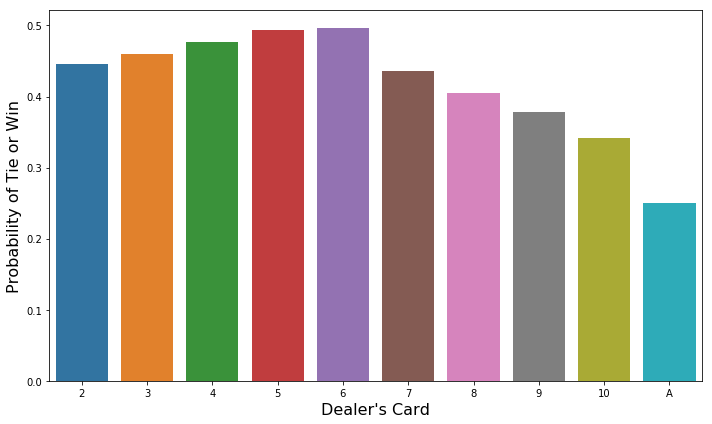

In [196]:
data = 1 - (model_df.groupby(by='dealer_card').sum()['lose'] /\
            model_df.groupby(by='dealer_card').count()['lose'])

fig, ax = plt.subplots(figsize=(10,6))
ax = sns.barplot(x=data.index, 
                 y=data.values)
ax.set_xlabel("Dealer's Card",fontsize=16)
ax.set_ylabel("Probability of Tie or Win",fontsize=16)

plt.tight_layout()
# plt.savefig(fname='dealer_card_probs', dpi=150)

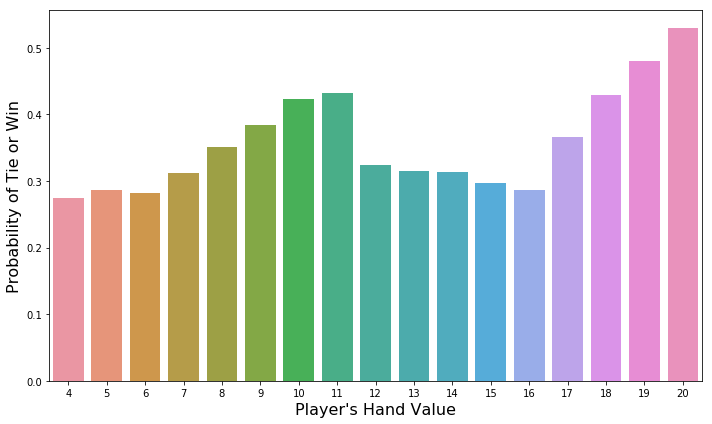

In [197]:
data = 1 - (model_df.groupby(by='player_total_initial').sum()['lose'] /\
            model_df.groupby(by='player_total_initial').count()['lose'])

fig, ax = plt.subplots(figsize=(10,6))
ax = sns.barplot(x=data[:-1].index,
                 y=data[:-1].values)
ax.set_xlabel("Player's Hand Value",fontsize=16)
ax.set_ylabel("Probability of Tie or Win",fontsize=16)

plt.tight_layout()
# plt.savefig(fname='player_hand_probs', dpi=150)

In [198]:
model_df.groupby(by='has_ace').sum()['lose'] / model_df.groupby(by='has_ace').count()['lose']

has_ace
0    0.642593
1    0.355287
Name: lose, dtype: float64

Text(123.0, 0.5, "Dealer's Card")

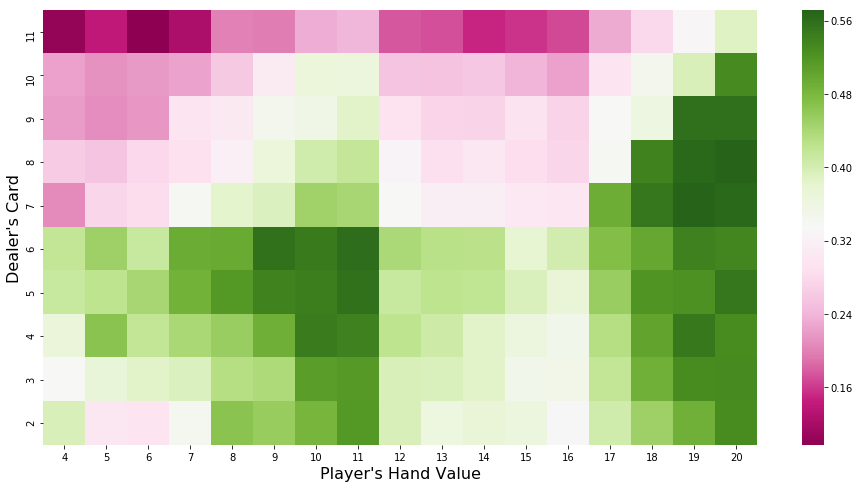

In [199]:
pivot_data = model_df[model_df['player_total_initial'] != 21]

losses_pivot = pd.pivot_table(pivot_data, values='lose', 
                              index=['dealer_card_num'],
                              columns = ['player_total_initial'],
                              aggfunc = np.sum)

games_pivot =  pd.pivot_table(pivot_data, values='lose', 
                              index=['dealer_card_num'],
                              columns = ['player_total_initial'],
                              aggfunc = 'count')

heat_data = 1 - losses_pivot.sort_index(ascending=False) / games_pivot.sort_index(ascending=False)

fig, ax = plt.subplots(figsize=(16,8))
sns.heatmap(heat_data, square=False, cmap="PiYG");

ax.set_xlabel("Player's Hand Value",fontsize=16)
ax.set_ylabel("Dealer's Card",fontsize=16)

# plt.savefig(fname='heat_map_random', dpi=150)

In [200]:
feature_list

['player_total_initial', 'hit?', 'has_ace', 'dealer_card_num']

In [201]:
# Train a neural net to play blackjack

# Set up variables for neural net
feature_list = [i for i in model_df.columns if i not in ['dealer_card',
                                                         'Y','lose',
                                                         'correct_action',
                                                         'dealer_bust',
                                                         'dealer_bust_pred',
                                                         'new_stack', 'games_played_with_stack',
                                                         2,3,4,5,6,7,8,9,10,'A',
                                                         'blackjack?'
                                                        ]]
train_X = np.array(model_df[feature_list])
train_Y = np.array(model_df['correct_action']).reshape(-1,1)

print(feature_list)
print('\n')

# Set up a neural net with 5 layers
model = Sequential()
# model.add(Dense(train_X.shape[1]+1))
model.add(Dense(16))
model.add(Dense(128))
model.add(Dense(32))
model.add(Dense(8))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='sgd')
model.fit(train_X, train_Y, epochs=200, batch_size=256, verbose=1)

pred_Y_train = model.predict(train_X)
actuals = train_Y[:,-1]

['player_total_initial', 'hit?', 'has_ace', 'dealer_card_num']


Epoch 1/200
257860/257860 [==============================] - 2s 7us/step - loss: 0.6949
Epoch 2/200
257860/257860 [==============================] - 1s 6us/step - loss: 0.6204
Epoch 3/200
257860/257860 [==============================] - 1s 6us/step - loss: 0.6166
Epoch 4/200
257860/257860 [==============================] - 2s 6us/step - loss: 0.6152
Epoch 5/200
257860/257860 [==============================] - 1s 6us/step - loss: 0.6143
Epoch 6/200
257860/257860 [==============================] - 1s 6us/step - loss: 0.6141
Epoch 7/200
257860/257860 [==============================] - 1s 6us/step - loss: 0.6142
Epoch 8/200
257860/257860 [==============================] - ETA: 0s - loss: 0.613 - 1s 6us/step - loss: 0.6139
Epoch 9/200
257860/257860 [==============================] - 1s 5us/step - loss: 0.6139
Epoch 10/200
257860/257860 [==============================] - 1s 5us/step - loss: 0.6138
Epoch 11/200
257860/257860 [==

257860/257860 [==============================] - 1s 5us/step - loss: 0.6129
Epoch 91/200
257860/257860 [==============================] - 1s 5us/step - loss: 0.6129
Epoch 92/200
257860/257860 [==============================] - 1s 5us/step - loss: 0.6129
Epoch 93/200
257860/257860 [==============================] - 2s 6us/step - loss: 0.6129
Epoch 94/200
257860/257860 [==============================] - 1s 6us/step - loss: 0.6129
Epoch 95/200
257860/257860 [==============================] - 1s 5us/step - loss: 0.6129
Epoch 96/200
257860/257860 [==============================] - 1s 5us/step - loss: 0.6129
Epoch 97/200
257860/257860 [==============================] - 1s 6us/step - loss: 0.6130
Epoch 98/200
257860/257860 [==============================] - 1s 5us/step - loss: 0.6129
Epoch 99/200
257860/257860 [==============================] - 1s 5us/step - loss: 0.6129
Epoch 100/200
257860/257860 [==============================] - 1s 6us/step - loss: 0.6130
Epoch 101/200
257860/257860 [====

257860/257860 [==============================] - 1s 5us/step - loss: 0.6129A: 0s - loss: 
Epoch 181/200
257860/257860 [==============================] - 1s 5us/step - loss: 0.6128
Epoch 182/200
257860/257860 [==============================] - 1s 6us/step - loss: 0.6128A: 0s - loss: 0.6
Epoch 183/200
257860/257860 [==============================] - 1s 5us/step - loss: 0.6128
Epoch 184/200
257860/257860 [==============================] - 1s 6us/step - loss: 0.6128
Epoch 185/200
257860/257860 [==============================] - 2s 6us/step - loss: 0.6128
Epoch 186/200
257860/257860 [==============================] - 1s 5us/step - loss: 0.6128
Epoch 187/200
257860/257860 [==============================] - 1s 5us/step - loss: 0.6128A: 0s -
Epoch 188/200
257860/257860 [==============================] - 1s 5us/step - loss: 0.6128
Epoch 189/200
257860/257860 [==============================] - 1s 5us/step - loss: 0.6128
Epoch 190/200
257860/257860 [==============================] - 1s 5us/step -

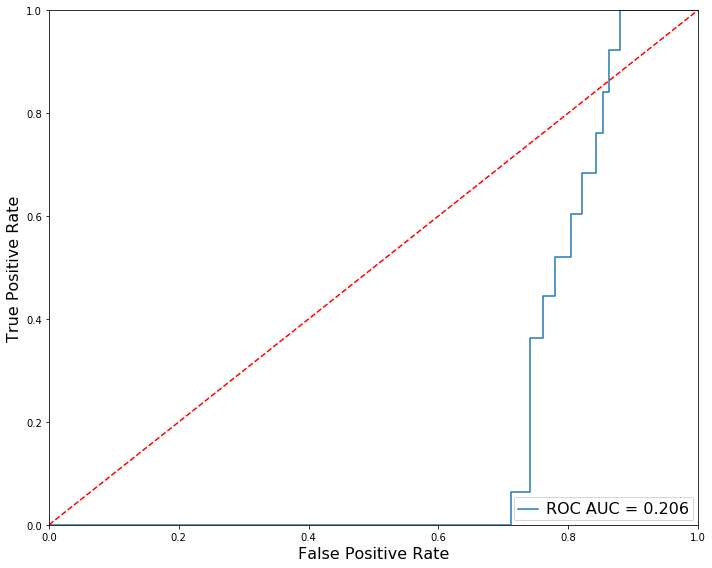

In [218]:
# Plot ROC Curve

fpr, tpr, threshold = metrics.roc_curve(actuals, pred_Y_train)
roc_auc = metrics.auc(fpr, tpr)

fig, ax = plt.subplots(figsize=(10,8))
plt.plot(fpr, tpr, label = ('ROC AUC = %0.3f' % roc_auc))

plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
ax.set_xlabel("False Positive Rate",fontsize=16)
ax.set_ylabel("True Positive Rate",fontsize=16)
plt.setp(ax.get_legend().get_texts(), fontsize=16)
plt.tight_layout()
plt.savefig(fname='roc_curve_blackjack', dpi=150)
plt.show()

In [219]:
def func(x):
    if x == 21:
        return 1
    else:
        return 0

model_df['blackjack?'] = model_df['player_total_initial'].apply(func)

In [204]:
# Train a neural net to PREDICT BLACKJACKS
# Apologize for the name, it started as a model to predict dealer busts
# Then I decided to predict blackjacks instead but neglected to rename it

bust_features = [2,3,4,5,6,7,8,9,10,'A','dealer_card_num']

# Set up variables for neural net
feature_list_bust = [i for i in bust_features if i not in ['dealer_bust']]
train_X_bust = np.array(model_df[feature_list_bust])
train_Y_bust = np.array(model_df['blackjack?']).reshape(-1,1)

print(feature_list_bust)
print('\n')

# Set up a neural net with 5 layers
model_bust = Sequential()
model_bust.add(Dense(train_X_bust.shape[1]))
model_bust.add(Dense(128))
model_bust.add(Dense(32, activation='relu'))
model_bust.add(Dense(8))
model_bust.add(Dense(1, activation='sigmoid'))
model_bust.compile(loss='binary_crossentropy', optimizer='sgd')
model_bust.fit(train_X_bust, train_Y_bust, epochs=200, batch_size=256, verbose=1)

pred_Y_train_bust = model_bust.predict(train_X_bust)
actuals = train_Y_bust[:,-1]

[2, 3, 4, 5, 6, 7, 8, 9, 10, 'A', 'dealer_card_num']


Epoch 1/200
257860/257860 [==============================] - 2s 7us/step - loss: 0.2010
Epoch 2/200
257860/257860 [==============================] - 2s 6us/step - loss: 0.1857
Epoch 3/200
257860/257860 [==============================] - 1s 6us/step - loss: 0.1816
Epoch 4/200
257860/257860 [==============================] - 1s 6us/step - loss: 0.1795
Epoch 5/200
257860/257860 [==============================] - 1s 5us/step - loss: 0.1781
Epoch 6/200
257860/257860 [==============================] - 1s 6us/step - loss: 0.1774
Epoch 7/200
257860/257860 [==============================] - 2s 6us/step - loss: 0.1769
Epoch 8/200
257860/257860 [==============================] - 1s 5us/step - loss: 0.1762
Epoch 9/200
257860/257860 [==============================] - 1s 6us/step - loss: 0.1751A: 0s - loss: 0.
Epoch 10/200
257860/257860 [==============================] - 1s 6us/step - loss: 0.1745
Epoch 11/200
257860/257860 [====================

257860/257860 [==============================] - 2s 6us/step - loss: 0.1683A: 0s - loss
Epoch 91/200
257860/257860 [==============================] - 2s 7us/step - loss: 0.1682
Epoch 92/200
257860/257860 [==============================] - 2s 7us/step - loss: 0.1683A: 0s - 
Epoch 93/200
257860/257860 [==============================] - 2s 6us/step - loss: 0.1681
Epoch 94/200
257860/257860 [==============================] - 2s 6us/step - loss: 0.1682A: 0s - loss
Epoch 95/200
257860/257860 [==============================] - 2s 6us/step - loss: 0.1682A: 0s - loss: 0.1 - ETA: 0s - loss: 0.1
Epoch 96/200
257860/257860 [==============================] - 2s 6us/step - loss: 0.1682
Epoch 97/200
257860/257860 [==============================] - 1s 6us/step - loss: 0.1681
Epoch 98/200
257860/257860 [==============================] - 2s 6us/step - loss: 0.1681
Epoch 99/200
257860/257860 [==============================] - 2s 6us/step - loss: 0.1681
Epoch 100/200
257860/257860 [=======================

257860/257860 [==============================] - 1s 5us/step - loss: 0.1671
Epoch 181/200
257860/257860 [==============================] - 1s 5us/step - loss: 0.1670
Epoch 182/200
257860/257860 [==============================] - 1s 5us/step - loss: 0.1670
Epoch 183/200
257860/257860 [==============================] - 1s 6us/step - loss: 0.1670
Epoch 184/200
257860/257860 [==============================] - 1s 5us/step - loss: 0.1670
Epoch 185/200
257860/257860 [==============================] - 1s 5us/step - loss: 0.1669
Epoch 186/200
257860/257860 [==============================] - 1s 5us/step - loss: 0.1670A: 0s - loss: 
Epoch 187/200
257860/257860 [==============================] - 1s 5us/step - loss: 0.1670
Epoch 188/200
257860/257860 [==============================] - 1s 6us/step - loss: 0.1669
Epoch 189/200
257860/257860 [==============================] - 1s 5us/step - loss: 0.1669
Epoch 190/200
257860/257860 [==============================] - 1s 6us/step - loss: 0.1670
Epoch 191/

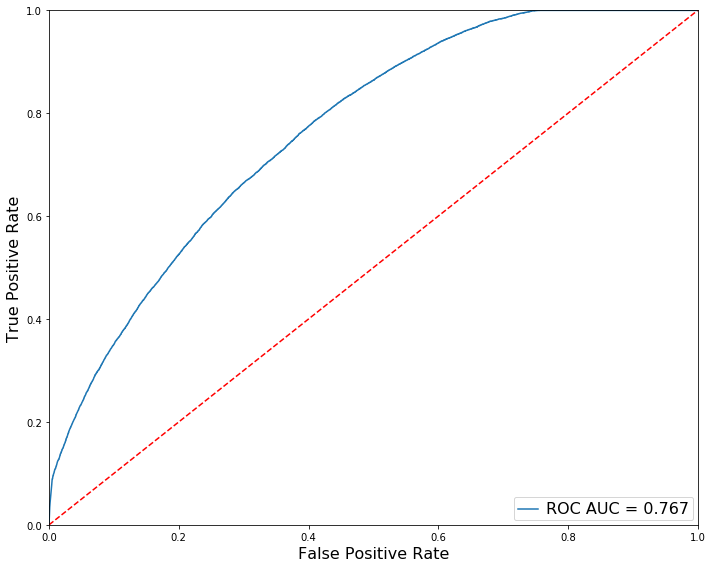

In [220]:
# Plot ROC Curve for predicting dealer bust

fpr, tpr, threshold = metrics.roc_curve(actuals, pred_Y_train_bust)
roc_auc = metrics.auc(fpr, tpr)

fig, ax = plt.subplots(figsize=(10,8))
plt.plot(fpr, tpr, label = ('ROC AUC = %0.3f' % roc_auc))

plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
ax.set_xlabel("False Positive Rate",fontsize=16)
ax.set_ylabel("True Positive Rate",fontsize=16)
plt.setp(ax.get_legend().get_texts(), fontsize=16)
plt.tight_layout()
plt.savefig(fname='roc_curve_blackjack', dpi=150)
plt.show()

In [206]:
# Given the relevant inputs, the function below uses the neural net to make a prediction
# and then based on that prediction, decides whether to hit or stay

def model_decision(model, player_sum, has_ace, dealer_card_num, new_stack, games_played, card_count):
    input_array = np.array([player_sum, 0, has_ace, 
                            dealer_card_num, new_stack, 
                            games_played]).reshape(1,-1)
    cc_array = pd.DataFrame.from_dict([card_count])
    input_array = np.concatenate([input_array, cc_array], axis=1)
    predict_correct = model.predict(input_array)
    if predict_correct >= 0.52:
        return 1, predict_correct
    else:
        return 0, predict_correct
    
def model_decision_old(model, player_sum, has_ace, dealer_card_num):
    input_array = np.array([player_sum, 0, has_ace, dealer_card_num]).reshape(1,-1)
    predict_correct = model.predict(input_array)
    if predict_correct >= 0.52:
        return 1
    else:
        return 0

In [207]:
def bust_Z_score(pred, pred_mean, pred_std):
    return (pred - pred_mean)/pred_std

pred_mean = model_bust.predict(train_X_bust).mean()
pred_std = model_bust.predict(train_X_bust).std()

In [269]:
# Play blackjack but use the neural net to make hit/stay decision
# And use a second neural net to decide how much to bet based on probability of dealer busting

nights = 101
bankrolls = []

for night in range(nights):
    
    dollars = 10000
    bankroll = []
    stacks = 101
    players = 1
    num_decks = 1

    card_types = ['A',2,3,4,5,6,7,8,9,10,10,10,10]

    dealer_card_feature = []
    player_card_feature = []
    player_live_total = []
    player_live_action = []
    player_results = []

    first_game = True
    prev_stack = 0
    stack_num_list = []
    new_stack = []
    card_count_list = []
    games_played_with_stack = []
    
    for stack in range(stacks):
        games_played = 0

        if stack != prev_stack:
            temp_new_stack = 1
        else:
            temp_new_stack = 0

        # Make a dict for keeping track of the count for a stack
        card_count = {2: 0,
                      3: 0,
                      4: 0,
                      5: 0,
                      6: 0,
                      7: 0,
                      8: 0,
                      9: 0,
                      10: 0,
                      'A': 0}

        blackjack = set(['A',10])
        dealer_cards = make_decks(num_decks, card_types)
        while len(dealer_cards) > 20:
            multiplier = 1

            curr_player_results = np.zeros((1,players))

            dealer_hand = []
            player_hands = [[] for player in range(players)]
            live_total = []
            live_action = []

            # Record card count
            cc_array_bust = pd.DataFrame.from_dict([card_count])

            # Deal FIRST card
            for player, hand in enumerate(player_hands):
                player_hands[player].append(dealer_cards.pop(0))
            dealer_hand.append(dealer_cards.pop(0))
            # Deal SECOND card
            for player, hand in enumerate(player_hands):
                player_hands[player].append(dealer_cards.pop(0))
            dealer_hand.append(dealer_cards.pop(0))

            # Record the player's live total after cards are dealt
            live_total.append(total_up(player_hands[player]))
            action = 0

            # Dealer checks for 21
            if set(dealer_hand) == blackjack:
                for player in range(players):
                    if set(player_hands[player]) != blackjack:
                        curr_player_results[0,player] = -1
                    else:
                        curr_player_results[0,player] = 0
            else:
                for player in range(players):
                    # Players check for 21
                    if set(player_hands[player]) == blackjack:
                        curr_player_results[0,player] = 1
                        multiplier = 1.25
                    else:
                        # Neural net decides whether to hit or stay
                        if 'A' in player_hands[player][0:2]:
                            ace_in_hand = 1
                        else:
                            ace_in_hand = 0
                        if dealer_hand[0] == 'A':
                            dealer_face_up_card = 11
                        else:
                            dealer_face_up_card = dealer_hand[0]

                        while (model_decision_old(model, total_up(player_hands[player]), 
                                                  ace_in_hand, dealer_face_up_card,
                                                  #temp_new_stack, games_played, 
                                                  #card_count
                                                 ) == 1) and (total_up(player_hands[player]) != 21):
                            player_hands[player].append(dealer_cards.pop(0))
                            action = 1
                            live_total.append(total_up(player_hands[player]))
                            if total_up(player_hands[player]) > 21:
                                curr_player_results[0,player] = -1
                                break

            # Dealer hits based on the rules
            while total_up(dealer_hand) < 17:
                dealer_hand.append(dealer_cards.pop(0))
            # Compare dealer hand to players hand but first check if dealer busted
            if total_up(dealer_hand) > 21:
                for player in range(players):
                    if curr_player_results[0,player] != -1:
                        curr_player_results[0,player] = 1
            else:
                for player in range(players):
                    if total_up(player_hands[player]) > total_up(dealer_hand):
                        if total_up(player_hands[player]) <= 21:
                            curr_player_results[0,player] = 1
                    elif total_up(player_hands[player]) == total_up(dealer_hand):
                        curr_player_results[0,player] = 0
                    else:
                        curr_player_results[0,player] = -1

            input_array = np.concatenate([cc_array_bust, 
                                          np.array(dealer_face_up_card).reshape(1,-1)], axis=1)
            bust_pred = model_bust.predict(input_array)
            bust_Z = bust_Z_score(bust_pred, pred_mean, pred_std)

            if bust_Z >= 0:
                bet = 100#*(1 + bust_Z_score)
            else:
                bet = 100
            dollars+=curr_player_results[0,player]*bet*multiplier
            bankroll.append(dollars)

            # Track features
            dealer_card_feature.append(dealer_hand[0])
            player_card_feature.append(player_hands)
            player_results.append(list(curr_player_results[0]))
            player_live_total.append(live_total)
            player_live_action.append(action)

            # Update card count list with most recent game's card count
            if stack != prev_stack:
                new_stack.append(1)
            else:
                new_stack.append(0)
                if first_game == True:
                    first_game = False
                else:
                    games_played += 1

            stack_num_list.append(stack)
            games_played_with_stack.append(games_played)
            card_count_list.append(card_count.copy())
            prev_stack = stack

    model_df_smart = pd.DataFrame()
    model_df_smart['dealer_card'] = dealer_card_feature
    model_df_smart['player_total_initial'] = [total_up(i[0][0:2]) for i in player_card_feature]
    model_df_smart['hit?'] = player_live_action

    has_ace = []
    for i in player_card_feature:
        if ('A' in i[0][0:2]):
            has_ace.append(1)
        else:
            has_ace.append(0)
    model_df_smart['has_ace'] = has_ace

    dealer_card_num = []
    for i in model_df_smart['dealer_card']:
        if i=='A':
            dealer_card_num.append(11)
        else:
            dealer_card_num.append(i)
    model_df_smart['dealer_card_num'] = dealer_card_num

    model_df_smart['Y'] = [i[0] for i in player_results]
    lose = []
    for i in model_df_smart['Y']:
        if i == -1:
            lose.append(1)
        else:
            lose.append(0)
    model_df_smart['lose'] = lose
    
    bankrolls.append(bankroll)

In [271]:
# bet_results = pd.DataFrame(bankrolls).T.fillna(method='ffill',axis=0)
# bet_results.to_csv('dumb_bet.csv')
# static_smart_bets = pd.read_csv('static_smart_bet.csv')
smart_bets = pd.read_csv('smart_bet.csv')
dumb_bets = pd.read_csv('dumb_bet.csv')

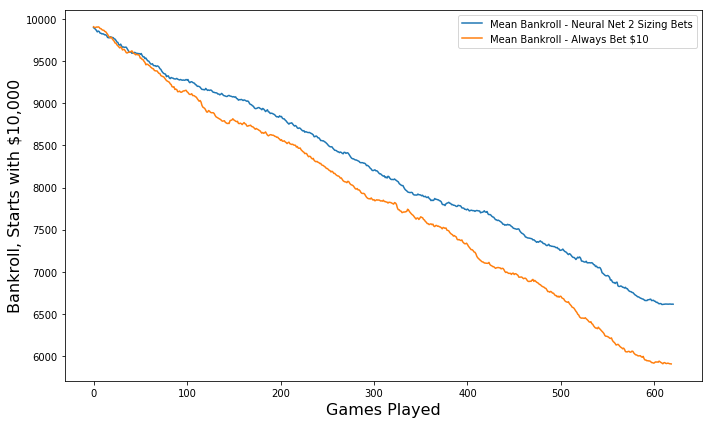

In [274]:
plt.subplots(figsize=(10,6))
plt.plot(smart_bets.mean(axis=1), label='Mean Bankroll - Neural Net 2 Sizing Bets');
plt.plot(dumb_bets.mean(axis=1), label='Mean Bankroll - Always Bet $10');
plt.xlabel('Games Played', fontsize=16)
plt.ylabel('Bankroll, Starts with $10,000', fontsize=16)
plt.legend()
plt.tight_layout()
plt.savefig('gamble_results', bpi=150)

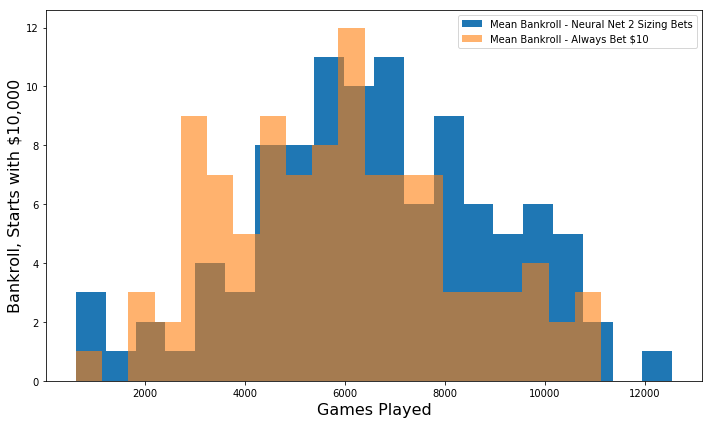

In [288]:
plt.subplots(figsize=(10,6))
plt.hist(smart_bets.iloc[-1], label='Mean Bankroll - Neural Net 2 Sizing Bets', bins=20);
plt.hist(dumb_bets.iloc[-1], label='Mean Bankroll - Always Bet $10', bins=20, alpha=0.6);
plt.xlabel('Games Played', fontsize=16)
plt.ylabel('Bankroll, Starts with $10,000', fontsize=16)
plt.legend()
plt.tight_layout()
plt.savefig('gamble_hist', bpi=150)

In [282]:
smart_bets.mean(axis=1).iloc[-1]/dumb_bets.mean(axis=1).iloc[-1] - 1

0.12006613622668261

In [223]:
model_df_smart.groupby(by='Y').count()['lose']/model_df_smart.shape[0]

Y
-1.0    0.49586
 0.0    0.08993
 1.0    0.41421
Name: lose, dtype: float64

In [224]:
print('Win or Tie Rate:', 1-model_df_smart.sum()['lose']/model_df_smart.count()['lose'])

Win or Tie Rate: 0.5041404438555813


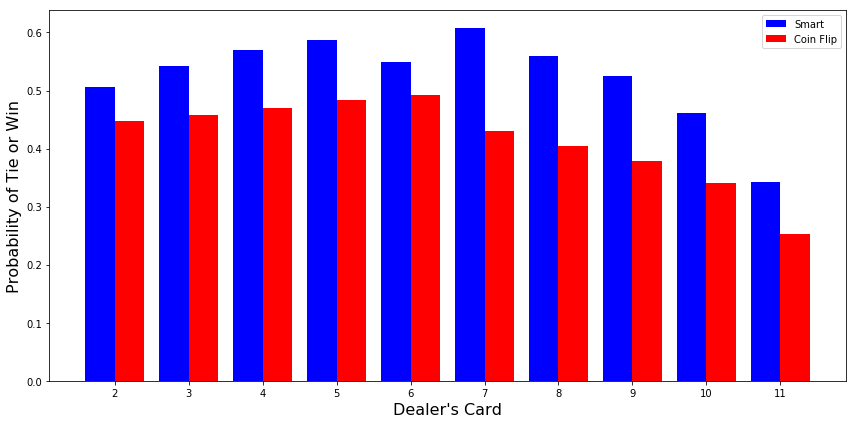

In [146]:
data_smart = 1 - (model_df_smart.groupby(by='dealer_card_num').sum()['lose'] /\
                  model_df_smart.groupby(by='dealer_card_num').count()['lose'])
data_random = 1 - (model_df.groupby(by='dealer_card_num').sum()['lose'] /\
                   model_df.groupby(by='dealer_card_num').count()['lose'])

data = pd.DataFrame()
data['smart'] = data_smart
data['random'] = data_random

fig, ax = plt.subplots(figsize=(12,6))
ax.bar(x=data.index-0.2, height=data['smart'].values, color='blue', width=0.4, label='Smart')
ax.bar(x=data.index+0.2, height=data['random'].values, color='red', width=0.4, label='Coin Flip')
ax.set_xlabel("Dealer's Card",fontsize=16)
ax.set_ylabel("Probability of Tie or Win",fontsize=16)
plt.xticks(np.arange(2, 12, 1.0))

plt.legend()
plt.tight_layout()
plt.savefig(fname='dealer_card_probs_smart', dpi=150)

In [153]:
# old = pd.read_csv('old_data_smart_dealer.csv', header=None)
# ax = pd.concat([data_smart, old.set_index(0)], axis=1).rename({'lose': 'With Card Count Data',
#                                                                1: 'No Card Count Data'},
#                                                                axis=1).plot(kind='bar', figsize=(12,6));
# ax.set_xlabel("Dealer's Card",fontsize=16)
# ax.set_ylabel("Probability of Tie or Win",fontsize=16)
# plt.tight_layout()
# plt.savefig('card_count_comp', bpi=150)

In [154]:
# data_smart = 1 - (model_df_smart.groupby(by='player_total_initial').sum()['lose'] /\
#                   model_df_smart.groupby(by='player_total_initial').count()['lose'])
# data_random = 1 - (model_df.groupby(by='player_total_initial').sum()['lose'] /\
#                    model_df.groupby(by='player_total_initial').count()['lose'])

# data = pd.DataFrame()
# data['smart'] = data_smart[:-1]
# data['random'] = data_random[:-1]

# fig, ax = plt.subplots(figsize=(12,6))
# ax.bar(x=data.index-0.2, height=data['smart'].values, color='blue', width=0.4, label='Smart')
# ax.bar(x=data.index+0.2, height=data['random'].values, color='red', width=0.4, label='Coin Flip')
# ax.set_xlabel("Player's Hand Value",fontsize=16)
# ax.set_ylabel("Probability of Tie or Win",fontsize=16)
# plt.xticks(np.arange(4, 21, 1.0))

# plt.legend()
# plt.tight_layout()
# plt.savefig(fname='player_hand_probs_smart', dpi=150)

In [155]:
# old = pd.read_csv('old_data_smart.csv', header=None)
# pd.concat([data_smart, old.set_index(0)], axis=1).plot();

In [156]:
# model_df_smart.groupby(by='player_total_initial').sum()['hit?']/model_df_smart.groupby(by='player_total_initial').count()['hit?']

In [157]:
# old_hit_prob = pd.read_csv('old_aces_only.csv', header=None)
# old_hit_prob.set_index(0, inplace=True)
# aces_only = model_df_smart[model_df_smart['dealer_card_num'].isin([2,3,4,5,6])]
# hit_prob = aces_only.groupby(by='player_total_initial').sum()['hit?']/aces_only.groupby(by='player_total_initial').count()['hit?']
# hit_prob = pd.concat([hit_prob, old_hit_prob], axis=1)
# hit_prob.rename({'hit?': 'Hit Prob. With Card Count Data',
#                  1: 'Hit Prob. No Card Count Data'}, axis=1, inplace=True)

In [158]:
# ax = hit_prob.plot(kind='bar', figsize=(12,6));
# ax.set_xlabel("Player's Hand Total",fontsize=16)
# ax.set_ylabel("Probability of Hitting",fontsize=16)
# plt.legend(loc='lower left')
# plt.tight_layout()
# plt.savefig('hit_prob_comp', bpi=150)